# Notebook to generate performance plot for each monkey.

This notebook requires the processed behavior data for the triangle task, saved
in `../../../cache/behavior/triangle.csv`. This can be downloaded from the GitHub
repo or can be generated by running the script
`../../../behavior_processing/run_cache_data.py`.

In [1]:
"""Imports."""

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sys
sys.path.append('../../../behavior_processing')
import load_triangle_data
import load_ring_data

# Matplotlib settings
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.dpi'] = 300

In [2]:
"""Load data."""

df_triangle = load_triangle_data.load_data()
df_triangle = df_triangle[df_triangle["on_triangle"]]
df_ring = load_ring_data.load_data()

# Add response_to_objects column to triangle data
response_to_objects = []
for _, row in df_triangle.iterrows():
    response_location = row['response_location']
    if np.isnan(response_location):
        response_to_objects.append(False)
        continue
    object_locations = row[[f"object_{i}_location" for i in range(3)]].values
    object_locations = np.array([x for x in object_locations if not np.isnan(x)]).astype(int)
    response_location = int(response_location)
    object_locations = object_locations[~np.isnan(object_locations)]
    if response_location in object_locations:
        response_to_objects.append(True)
    else:
        response_to_objects.append(False)
df_triangle['response_to_objects'] = response_to_objects

# Add response_to_objects column to ring data
response_to_objects = []
for _, row in df_ring.iterrows():
    response_object_0 = row['response_object_0']
    response_object_1 = row['response_object_1']
    if response_object_0 or response_object_1:
        response_to_objects.append(True)
    else:
        response_to_objects.append(False)
df_ring['response_to_objects'] = response_to_objects

# Combine dataframes
keep_columns = ["num_objects", "correct", "subject", "response_to_objects"]
df_ring = df_ring[keep_columns]
df_triangle = df_triangle[keep_columns]
df_triangle["task"] = "triangle"
df_ring["task"] = "ring"
df = pd.concat([df_triangle, df_ring])

# Rename subject column to "P" and "E" instead of "Perle" and "Elgar"
df["subject"] = df["subject"].apply(lambda x: x[0])

Monkey P, 1 objects, performance: 0.953
Monkey P, 2 objects, performance: 0.93
Monkey P, 3 objects, performance: 0.692
Monkey P, 1 objects, response-to-object performance: 1.0
Monkey P, 2 objects, response-to-object performance: 0.941
Monkey P, 3 objects, response-to-object performance: 0.7
Monkey E, 1 objects, performance: 0.928
Monkey E, 2 objects, performance: 0.759
Monkey E, 3 objects, performance: 0.561
Monkey E, 1 objects, response-to-object performance: 1.0
Monkey E, 2 objects, response-to-object performance: 0.774
Monkey E, 3 objects, response-to-object performance: 0.562


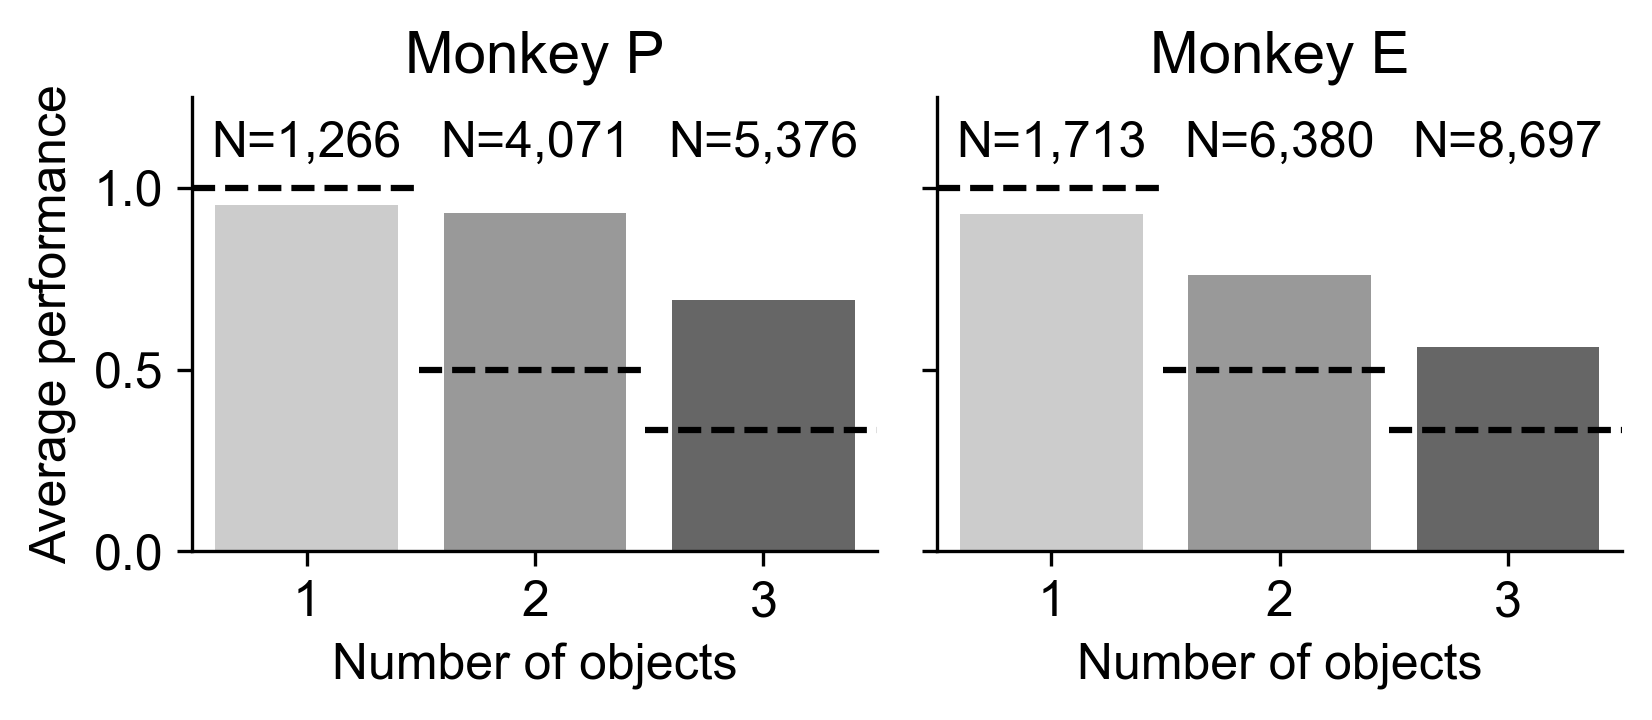

In [3]:
""""Plot average performance per subject."""

PALETTE = {
    1: (0.8, 0.8, 0.8),
    2: (0.6, 0.6, 0.6),
    3: (0.4, 0.4, 0.4),
}

# Average performance per number of objects per subject
fig, axes = plt.subplots(1, 2, figsize=(5.7, 2.5), sharey=True)
for subject, ax in zip(['P', 'E'], axes):
    sns.despine(ax=ax)
    subject_df = df[
        (df['subject'] == subject)
        & (df['task'] == "triangle")
    ]
    sns.barplot(
        ax=ax, data=subject_df,
        x='num_objects', y='correct',
        hue="num_objects",
        palette=PALETTE,
        errorbar=None,
        legend=False,
    )
    ax.set_title(f'Monkey {subject}')
    ax.set_xlabel('Number of objects')
    ax.set_ylabel('Average performance')
    ax.set_ylim(0, 1)
    
    # Add horizontal line at 0.5 for Number of objects = 1
    ax.axhline(1., color='black', linestyle='--', xmin=0, xmax=0.33)
    
    # Add horizontal line at 0.5 for Number of objects = 2
    ax.axhline(0.5, color='black', linestyle='--', xmin=0.33, xmax=0.66)
    
    # Add horizontal line at 0.33 for Number of objects = 3
    ax.axhline(1./3, color='black', linestyle='--', xmin=0.66, xmax=1)
    
    # For each number of objects, add text for number of trials
    ax.set_ylim(0, 1.25)
    for n in range(1, 4):
        n_trials = subject_df[subject_df['num_objects'] == n].shape[0]
        n_trials_string = '{:,}'.format(n_trials)
        ax.text(n - 1, 1.12, f'N={n_trials_string}', ha='center', va='center', fontsize=12)
        
    # Print performance for each number of objects
    for n in range(1, 4):
        performance = subject_df[subject_df['num_objects'] == n]['correct'].mean()
        performance = round(performance, 3)
        print(f'Monkey {subject}, {n} objects, performance: {performance}')
        
    # Print performance for each number of objects, given responded to some object
    for n in range(1, 4):
        performance = subject_df[
            (subject_df['num_objects'] == n)
            & (subject_df['response_to_objects'])
        ]['correct'].mean()
        performance = round(performance, 3)
        print(f'Monkey {subject}, {n} objects, response-to-object performance: {performance}')
    
fig.tight_layout()

# Save figure
plt.savefig('./performance.pdf', bbox_inches='tight', pad_inches=0.01)